In [26]:
import numpy as np
import Code
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

Avant toute chose, on tire une valeur du paramètre $\theta$ que l'on considère comme étant la quantité que l'on souhaite approximer dans la suite de cette partie. On sait d'après le cadre de l'application numérique de l'article que $\theta \sim \mathcal{N}(\theta\mathbf{1}_{20}, 2I_{20})$. 

In [15]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {theta_true}")

La valeur de theta à estimer est -2.877187723383175


### <span style="color:orange">  **Cadre général de la descente de gradient stochastique pour obtenir une estimation du maximum de vraisemblance**  </span>

Soit $\boldsymbol{x}$ un ensemble de variables aléatoires observées et $\theta$ le paramètre du modèle probabiliste que nous souhaitons estimer. La vraisemblance des données observées $p_{\theta}(\boldsymbol{x})$ est maximisée pour obtenir une estimation de maximum de vraisemblance (EMV) du paramètre $\theta$. En utilisant la **descente de gradient stochastique (SGD)**, l'algorithme pour estimer les paramètres peut être formulé comme suit :


1. **Initialisation** : On choisit un $\theta^{(0)}$ De manière aléatoire ou déterministe. On peut par exemple choisir une telle valeur à partir d'une première approximation.

2. **Itération** : À chaque itération $t$, les paramètres $\theta$ sont mis à jour en utilisant un échantillon aléatoire de données $x^{(i)}$ tiré de l'ensemble de données paramétré par $\theta^{(t)}$ et on a alors : 
\begin{equation}
\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} \log p(\boldsymbol{x}^{(i)} | \theta^{(t)}),
\end{equation}

    où $\eta$ est le **taux d'apprentissage** (également appelé pas d'apprentissage) et $\nabla_{\theta} \log p_{\theta^{(t)}}(\boldsymbol{x}^{(i)})$ est le gradient du logarithme de la vraisemblance conditionnelle évalué pour l'échantillon $\boldsymbol{x}^{(i)}$ à l'itération $t$. 

3. **Convergence** : On répète $(1)$ jusqu'à ce qu'un critère d'arrêt prédéfini soit satisfait, tel qu'un nombre maximal d'itérations atteint ou une convergence suffisante des paramètres.


Dans l'article, pour effectuer l'expérience empirique, on nous donne la valeur explicite de la densité avec laquelle on tire les observations $\boldsymbol{x}$. On nous donne : 

$$
p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)
$$

In [16]:
def p_theta_x(theta_val):
    
    x = np.random.multivariate_normal(mean=theta_val * np.ones(20), cov=np.eye(20))

    return x

On code désormais la partie itérative de l'algorithme de descentes de gradient stochastique.

In [17]:
## calcul du gradient 

def grad_theta(x, r, noised_A, noised_b, theta_true, k_IWAE, n_simulations, method):

    theta_min = theta_true - 5  # Limite inférieure de la plage
    theta_max = theta_true + 5 # Limite supérieure de la plage
    num_points = 51  # Pour inclure theta_true au milieu # Nombre de points à générer
    theta_values = np.linspace(theta_min, theta_max, num_points)

    grad = 0

    if method == 'IWAE':
        ## on caclue les valeurs de IWAE sur cette plage de valeurs
        IWAE_values = [Code.log_likelihood_IWAE(theta, x, noised_A, noised_b, k_IWAE, n_simulations) for theta in theta_values]

        grad = np.gradient(IWAE_values)[25]

    if method == 'SUMO':
        SUMO_values = [Code.log_likelihood_SUMO(r, theta, x, noised_A, noised_b, n_simulations) for theta in theta_values]

        grad = np.gradient(SUMO_values)[25]

    if method == 'ML_SS':
        ML_SS_values = [Code.log_likelihood_ML_SS(r, theta, x, noised_A, noised_b, n_simulations) for theta in theta_values]

        grad = np.gradient(ML_SS_values)[25]

    if method == 'ML_RR':
        ML_RR_values = [Code.log_likelihood_ML_RR(r, theta, x, noised_A, noised_b, n_simulations) for theta in theta_values]

        grad = np.gradient(ML_RR_values)[25]

    return grad

In [30]:
def SGD_iteration(theta_t, eta, r, k_IWAE, n_simulations, method):

    ## on tire un échantillon aléatoire de données SELON LE PARAMÈTRE PRÉCÉDENT theta_t
    x = p_theta_x(theta_t)

    ## on recalcule noised_A et noised_b SELON LE PARAMÈTRE PRÉCÉDENT theta_t
    A, b = np.eye(20), (theta_t/2)*np.ones(20)
    noised_A, noised_b = Code.noised_params(A, b)
    
    ## on calcule le gradient selon l'estimateur donné dans method
    grad_theta_t = grad_theta(x, r, noised_A, noised_b, theta_t, k_IWAE, n_simulations, method)

    theta_next =  theta_t - eta * grad_theta_t

    return theta_next

Une fois le code pour les itération fini, on s'attaque à la convergence de l'algorithme de descendre de gradient stochastique rien

In [31]:
def SGD_convergence(n_iterations, theta_0, eta, r, k_IWAE, n_simulations, method):

    theta_t = [theta_0]

    progress_bar = tqdm(total=n_iterations, desc='Progression', position=0)
    
    for i in range(n_iterations):

        theta_next = SGD_iteration(theta_t[i], eta, r, k_IWAE, n_simulations, method)
        theta_t.append(theta_next)
        time.sleep(0.01)
        progress_bar.update(1)

    progress_bar.close()

    return theta_t

In [32]:
n_iterations = 50
theta_0 = theta_true - 10e-2
eta = 2.5*10e-4
r = 0.6
k_IWAE = 5
n_simulations = 5 
method = 'ML_RR'

SGD_conv = SGD_convergence(n_iterations, theta_0, eta, r, k_IWAE, n_simulations, method)

Progression:  46%|████▌     | 23/50 [00:57<01:34,  3.48s/it]/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:245: RuntimeWarning: divide by zero encountered in log
  
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:249: RuntimeWarning: divide by zero encountered in log
  weights_array_odd = weights(x, z_sample_odd_theta, theta, noised_A, noised_b)
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:247: RuntimeWarning: divide by zero encountered in log
  weights_array = weights(x, z_sample_theta, theta, noised_A, noised_b)
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:248: RuntimeWarning: divide by zero encountered in log
  
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:252: RuntimeWarning: invalid value encountered in scalar subtract
  #weights_array_even = np.log(weights_array[::2])
/Users/khelifanail/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Cod

In [33]:
def plot_convergence(convergence_values, theta_true):
    """
    Trace la convergence des points vers la valeur du vrai paramètre.

    Args:
    - convergence_values (list or numpy array): Liste des valeurs de convergence de l'algorithme.
    - theta_true (float): Valeur vraie du paramètre.

    """
    num_iterations = len(convergence_values)
    iterations = np.arange(1, num_iterations + 1)  # Numéro des itérations

    plt.figure(figsize=(10, 6))
    plt.scatter(iterations, convergence_values, color='blue', label='Convergence')
    plt.axhline(y=theta_true, color='red', linestyle='--', label='True Parameter Value')

    plt.title('Convergence vers la valeur du vrai paramètre')
    plt.xlabel('Iterations')
    plt.ylabel('Valeur de convergence')
    plt.legend()
    plt.grid(True)
    plt.show()


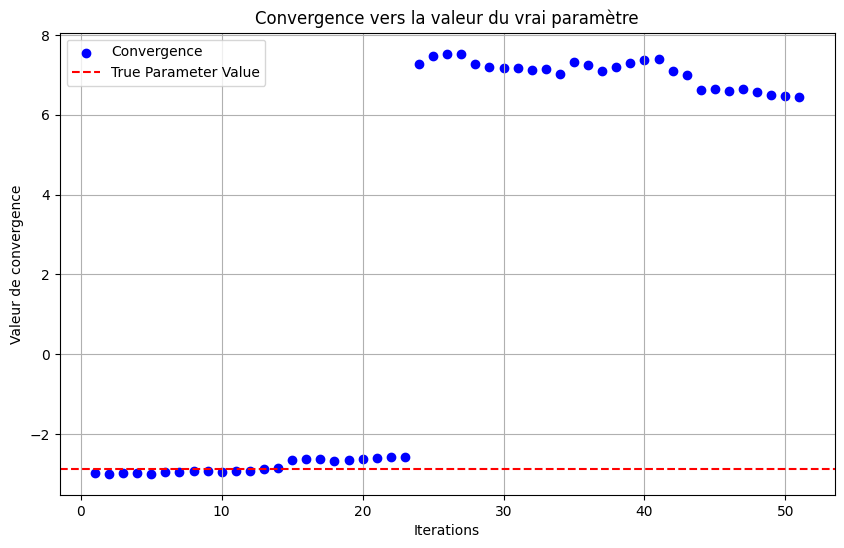

In [34]:
plot_convergence(SGD_conv, theta_true)